# 1. Import and Install Dependencies

In [82]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib arabic_reshaper python-bidi

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import arabic_reshaper
from bidi.algorithm import get_display

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [53]:
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:  
    image = cv2.imread("Data/train/0001/01_01_0001_(08_12_16_15_35_44)_c/01_01_0001_(08_12_16_15_35_44)_c_0001.jpg")
    image, results = mediapipe_detection(image, holistic)
                
    # # Draw landmarks
    # draw_styled_landmarks(image, results)
    # cv2.imshow('Image', image)
    # cv2.waitKey(0)
    

    # Make detections
    image, results = mediapipe_detection(image, holistic)
                
    # Draw landmarks
    draw_styled_landmarks(image, results)

    # Show image
    cv2.imshow('Image', image)
    cv2.waitKey(0)

# cv2.destroyAllWindows()

In [29]:
draw_styled_landmarks(frame, results)

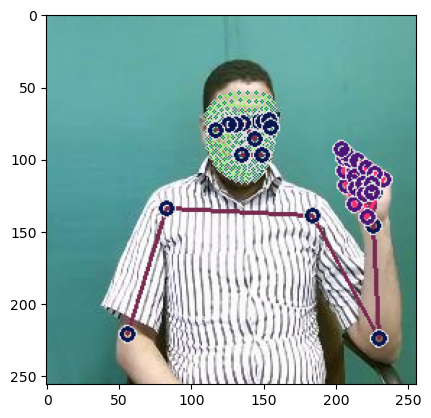

In [30]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [31]:
len(results.left_hand_landmarks.landmark)

21

In [32]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [33]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [34]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)


In [35]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [36]:
result_test = extract_keypoints(results)

In [37]:
result_test

array([ 0.56256342,  0.33665502, -0.53424156, ...,  0.        ,
        0.        ,  0.        ])

# 5. Collect Keypoint Values for Training

In [ ]:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    dataset_path = 'Data/train'  # Path to the dataset folder
    datanp_path = 'Datanp/train'
    categories = os.listdir(dataset_path)  # Get the list of categories (subfolders)
    for category in categories:
        category_path = os.path.join(dataset_path, category)  # Path to the category folder
        subs = os.listdir(category_path)  # Get the list of subfolders within the category

        for sub in subs:
            subfolder_path = os.path.join(category_path, sub)  # Path to the subfolder
            image_files = os.listdir(subfolder_path)  # Get the list of image files in the subfolder

            for counter, image_file in enumerate(image_files):
                image_path = os.path.join(subfolder_path, image_file)  # Path to the image file
                print(image_path)
                image = cv2.imread(image_path)

                # Make detections
                image, results = mediapipe_detection(image, holistic)
                keypoints = extract_keypoints(results)

                npy_dir = os.path.join(datanp_path, category,sub)
                os.makedirs(npy_dir, exist_ok=True)  # Create the directory hierarchy if it doesn't exist

                npy_path = os.path.join(npy_dir,str(counter))
                np.save(npy_path, keypoints)

# 6. Collect Keypoint Values for Testing

In [ ]:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    dataset_path = 'Data/test'  # Path to the dataset folder
    datanp_path = 'Datanp/test'
    categories = os.listdir(dataset_path)  # Get the list of categories (subfolders)
    for category in categories:
        category_path = os.path.join(dataset_path, category)  # Path to the category folder
        subs = os.listdir(category_path)  # Get the list of subfolders within the category

        for sub in subs:
            subfolder_path = os.path.join(category_path, sub)  # Path to the subfolder
            image_files = os.listdir(subfolder_path)  # Get the list of image files in the subfolder

            for counter,image_file in enumerate(image_files):
                image_path = os.path.join(subfolder_path, image_file)  # Path to the image file
                print(image_path)
                image = cv2.imread(image_path)

                # Make detections
                image, results = mediapipe_detection(image, holistic)
                keypoints = extract_keypoints(results)

                npy_dir = os.path.join(datanp_path, category,sub)
                os.makedirs(npy_dir, exist_ok=True)  # Create the directory hierarchy if it doesn't exist

                npy_path = os.path.join(npy_dir,str(counter))
                np.save(npy_path, keypoints)

# 6. Preprocess Data and Create Labels and Features

In [80]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [62]:
import pandas as pd
df = pd.read_csv("KARSL-190_Labels.csv")

In [181]:
sign_dict = {}

for i in range(0, 10):  # Loop from index 1 to 10 (inclusive)
    sign_id = df.loc[i, "SignID"]
    sign_arabic = df.loc[i, "Sign-Arabic"]
    sign_dict[sign_id] = sign_arabic

print(sign_dict)

{1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9'}


In [182]:
sequences, labels = [], []
datanp_path = 'Datanp/train'
categories = os.listdir(datanp_path)

for category in categories:
    category_path = os.path.join(datanp_path, category)
    subs = os.listdir(category_path)
    
    for sub in subs:
        sub_path = os.path.join(category_path, sub)
        datas = os.listdir(sub_path)
        
        # window = []
        for data in datas:
            res = np.load(os.path.join(sub_path, data))
            # window.append(res)
        
        sequences.append(res)
        labels.append(sign_dict[int(category)]) 

In [183]:
np.array(sequences).shape

(422, 1662)

In [184]:
np.array(labels).shape

(422,)

In [185]:
X = np.array(sequences)

In [186]:
X.shape

(422, 1662)

In [187]:
y = to_categorical(labels).astype(int)

In [188]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

# 7. Build and Train LSTM Neural Network

In [167]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [168]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [95]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(442,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

In [96]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [97]:
model.fit(X, y, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000


ValueError: in user code:

    File "C:\Users\Yehia\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Yehia\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Yehia\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Yehia\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Yehia\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Yehia\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_9' (type Sequential).
    
    Input 0 of layer "lstm_21" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1662)
    
    Call arguments received by layer 'sequential_9' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1662), dtype=float32)
      • training=True
      • mask=None


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 596675 

# 8. Make Predictions

In [35]:
res = model.predict(X_test)

1/1 [==============================] - 0s 396ms/step


In [36]:
y_test

array([[0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0]])

In [37]:
actions[np.argmax(res[8])]

'hello'

In [38]:
actions[np.argmax(y_test[8])]

'hello'

# 9. Save Weights

In [60]:
model.save('initial.keras')

In [217]:
del model

In [34]:
model.load_weights('initial.keras')

# 10. Evaluation using Confusion Matrix and Accuracy

In [39]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [40]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 32ms/step


In [41]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [42]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[ 9,  0],
        [ 0,  2]],

       [[10,  0],
        [ 0,  1]],

       [[10,  0],
        [ 0,  1]],

       [[ 9,  0],
        [ 1,  1]],

       [[ 8,  2],
        [ 0,  1]],

       [[ 9,  0],
        [ 1,  1]],

       [[ 9,  0],
        [ 0,  2]]], dtype=int64)

In [43]:
accuracy_score(ytrue, yhat)

0.8181818181818182

# 11. Test in Real Time

In [44]:
from scipy import stats

In [45]:
colors = [(245,117,16), (117,245,16), (16,117,245),(255, 0, 0),(0, 255, 0),(0, 0, 255),(255, 255, 0)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [46]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [48]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti